### Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import random

from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
from more_itertools import chunked

n_shot = 1
n_class = 10
n_local_update = 5
batch_size = n_class

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TODO ↓消す
def batchnorm(input, weight=None, bias=None, running_mean=None, running_var=None, training=True, eps=1e-5, momentum=0.1):
    ''' momentum = 1 restricts stats to the current mini-batch '''
    # This hack only works when momentum is 1 and avoids needing to track running stats
    # by substuting dummy variables
    running_mean = torch.zeros(np.prod(np.array(input.data.size()[1]))).cuda()
    running_var = torch.ones(np.prod(np.array(input.data.size()[1]))).cuda()
    return F.batch_norm(input, running_mean, running_var, weight, bias, training, momentum, eps)


class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        
        self.h=64
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.fc = nn.Linear(self.h, n_class)

    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(x.size(0), self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    # for MAML local optimize
    def manual_forward(self, x, params):
        
        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        x = batchnorm(x, weight = params['bn1.weight'], bias = params['bn1.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        x = batchnorm(x, weight = params['bn2.weight'], bias = params['bn2.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        x = batchnorm(x, weight = params['bn3.weight'], bias = params['bn3.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = x.view(x.size(0), self.h)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)
        
        return x
    
    
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            
            test_loss += loss
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

### Dataset

In [2]:
class OmniglotOriginDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_index, transform):

        self.data = []
        self.path = path_to_lang
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # 各文字20枚ずつ入ってる
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### AugmentedDataset

In [3]:
class OmniglotAugmentedDataset(Dataset):
    def __init__(self, path_to_chars, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError
        
        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_chars, train_indices)):
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # 各文字20枚ずつ入ってる
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### DataLoader

../data/omniglot_mini/images_background/Latin/


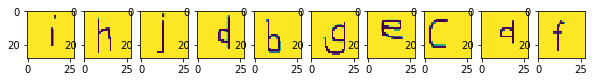

y_true: tensor([8, 7, 9, 3, 1, 6, 4, 2, 0, 5])


In [4]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

print(local_task_train_data_loader.dataset.path)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

### AugmentDataLoader

local_task_train_data


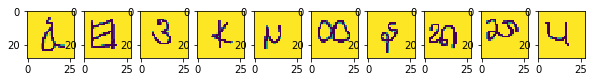

y_true: tensor([9, 0, 7, 2, 1, 8, 4, 3, 5, 6])

local_task_train_data


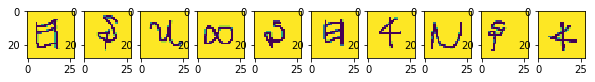

y_true: tensor([0, 4, 6, 8, 4, 0, 2, 1, 4, 2])


In [5]:
train_indices = np.random.randint(20, size=(n_class, n_shot))

path_to_chars = [
    '../data/omniglot_mini/images_background/Early_Aramaic/character08',
    '../data/omniglot_mini/images_background/N_Ko/character05',
    '../data/omniglot_mini/images_background/Early_Aramaic/character01',
    '../data/omniglot_mini/images_background/Balinese/character04',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character21',
    '../data/omniglot_mini/images_background/Balinese/character03',
    '../data/omniglot_mini/images_background/Gujarati/character35',
    '../data/omniglot_mini/images_background/Bengali/character10',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character18',
    '../data/omniglot_mini/images_background/Armenian/character17'
]

print("local_task_train_data")
local_task_train_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=True,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

print("\nlocal_task_train_data")
local_task_test_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=False,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break

### (fitting)

100%|██████████| 10/10 [00:00<00:00, 50.91it/s, epoch=10, train_loss=0.0787, train_acc=1, test_loss=2.07, test_acc=0.311]


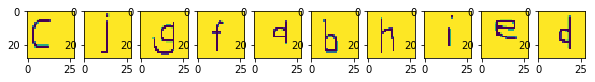

y_pred: tensor([2, 9, 6, 5, 0, 1, 7, 8, 4, 3])
y_true: tensor([2, 9, 6, 5, 0, 1, 7, 8, 4, 3])


In [6]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)


local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
a=0
with tqdm(range(10)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

### Taskset and TaskLoader classes

In [7]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return len(self.taskset)

### Taskset

In [8]:
class OmniglotOriginTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_langs))
        tasks = [os.path.join(path_to_langs, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=n_class]
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_index=[np.random.randint(20)] #TODO chanege indices
        return {"train":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx], 
                                    n_class=n_class,
                                    train=True,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx],
                                    n_class=n_class,
                                    train=False,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### AugmentedTaskset

In [9]:
class OmniglotAugmentedTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
            
        chars = []
        
        for path_to_lang in os.listdir(path_to_langs):
            path_to_chars = os.path.join(path_to_langs, path_to_lang)
            for path_to_char in os.listdir(path_to_chars):
                chars.append(os.path.join(path_to_chars, path_to_char)) 
        
        random.shuffle(chars)
        tasks = list(chunked(chars, n_class))[:-1] # drop_last
        
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_indices = np.random.randint(20, size=(n_class, n_shot))
        return {"train":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### TaskLoader

30
../data/omniglot_mini/images_background/N_Ko


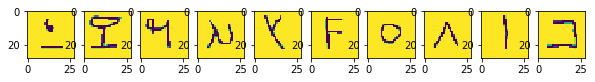

tensor([7, 6, 8, 4, 2, 9, 1, 3, 0, 5])
../data/omniglot_mini/images_background/Braille


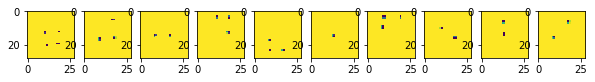

tensor([6, 9, 2, 3, 7, 0, 5, 4, 1, 8])
../data/omniglot_mini/images_background/Asomtavruli_(Georgian)


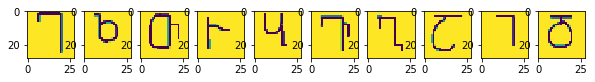

tensor([4, 6, 8, 7, 1, 5, 2, 0, 9, 3])


In [10]:
meta_train_task_loader = TaskLoader(
    OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    if i==2:
        break

### AugmentTaskLoader

96
['../data/omniglot_mini/images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)/character11', '../data/omniglot_mini/images_background/Japanese_(hiragana)/character38', '../data/omniglot_mini/images_background/Malay_(Jawi_-_Arabic)/character06', '../data/omniglot_mini/images_background/Gujarati/character09', '../data/omniglot_mini/images_background/Gujarati/character34', '../data/omniglot_mini/images_background/Armenian/character39', '../data/omniglot_mini/images_background/Mkhedruli_(Georgian)/character09', '../data/omniglot_mini/images_background/Blackfoot_(Canadian_Aboriginal_Syllabics)/character06', '../data/omniglot_mini/images_background/Sanskrit/character22', '../data/omniglot_mini/images_background/Alphabet_of_the_Magi/character02']
train


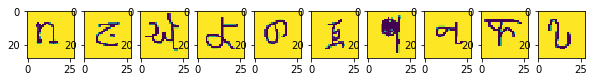

tensor([5, 2, 3, 1, 6, 9, 7, 4, 8, 0])
test


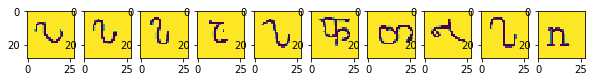

tensor([0, 0, 0, 2, 0, 8, 6, 4, 0, 5])
['../data/omniglot_mini/images_background/Asomtavruli_(Georgian)/character32', '../data/omniglot_mini/images_background/Early_Aramaic/character08', '../data/omniglot_mini/images_background/Tagalog/character09', '../data/omniglot_mini/images_background/Malay_(Jawi_-_Arabic)/character22', '../data/omniglot_mini/images_background/Syriac_(Estrangelo)/character14', '../data/omniglot_mini/images_background/Tagalog/character13', '../data/omniglot_mini/images_background/Mkhedruli_(Georgian)/character13', '../data/omniglot_mini/images_background/Korean/character24', '../data/omniglot_mini/images_background/Japanese_(katakana)/character45', '../data/omniglot_mini/images_background/Mkhedruli_(Georgian)/character25']
train


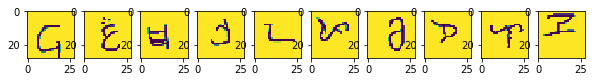

tensor([0, 3, 1, 9, 7, 5, 6, 4, 2, 8])
test


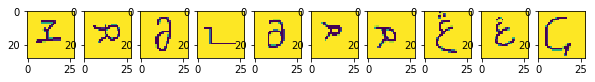

tensor([8, 4, 6, 7, 6, 4, 4, 3, 3, 0])


In [11]:
meta_train_task_loader = TaskLoader(
    OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    print("test")
    local_task_test_data_loader = meta_train_task["test"]
    for data, target in local_task_test_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
        break
    if i==1:
        break

---

# MAML

In [12]:
from copy import deepcopy
from time import sleep

class MetaLearner(object):
    def __init__(self):
        self.lr = 0.1
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    #TODO need return or not
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def meta_test(self):
        
        meta_test_task_loader = TaskLoader(
            OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        test_loss, test_acc = [], []
        
        sleep(0.5)
        with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
            for meta_test_task in _tqdm:

                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)
                faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)

                # make local task data loader
                local_task_train_data_loader = meta_test_task["train"]
                local_task_test_data_loader = meta_test_task["test"]

                # ----------------------------------------------------------------
                # meta test task train
                # ----------------------------------------------------------------

                for epoch in range(n_local_update):
                    train_loss, train_acc = train(
                        faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(train_loss), 
                        train_acc="{:.3f}".format(train_acc)))
                # ----------------------------------------------------------------
                # meta test task test
                # ----------------------------------------------------------------

                loss, acc = test(faster_net, self.device, local_task_test_data_loader)
                test_loss.append(loss)
                test_acc.append(acc)
        
        return np.mean(test_loss), np.mean(test_acc)

    
    def meta_train(self):
        
#         meta_train_task_loader = TaskLoader(
#             OmniglotTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
        meta_train_task_loader = TaskLoader(
            OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
    
        sleep(0.5)
        with tqdm(meta_train_task_loader, desc="Meta Train", ncols=10) as _tqdm:
            for meta_train_task in _tqdm:

                meta_grads = []


                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)

                faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())
                master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())

                # make local task data loader
                local_task_train_data_loader = meta_train_task["train"]
                local_task_test_data_loader = meta_train_task["test"]






    #             for name, param in self.master_net.named_parameters():
    #                 print(name, param[0].grad)
    #                 break







                # ----------------------------------------------------------------
                # meta train task test pre1
                # ----------------------------------------------------------------

                pre_test_loss = []

                for data, target in local_task_test_data_loader:
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)

    #                 print(output[0])

    #                 output_ = self.master_net(data)

    #                 print(output_[0])


                    loss = F.nll_loss(output, target)
                    pre_test_loss.append(loss.item())

                pre_test_loss = np.mean(pre_test_loss)













                # ----------------------------------------------------------------
                # meta train task train
                # ----------------------------------------------------------------

    #             print("\n#","-"*60)
    #             print("# meta train task train")
    #             print("#","-"*60, "\n")

                # train n_local_update times / 1 task
                first_train_for_this_task = True

                for epoch in range(n_local_update):

                    for data, target in local_task_train_data_loader:

                        data, target = data.to(self.device), target.to(self.device)

                        if first_train_for_this_task:
                            # manual predict
                            output = self.master_net(data) # あとでmaster_netのパラメタで微分するので
                            loss = F.nll_loss(output, target)

                            # manual optimize
    #                         grads = torch.autograd.grad(loss, self.master_net.parameters())
                            grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                            first_train_for_this_task = False

                        else:
                            # manual predict
                            output = faster_net.manual_forward(data, faster_params)
                            loss = F.nll_loss(output, target)

    #                         if epoch>0:
    #                             print(epoch+1, loss.item())
                            # manual optimize
    #                         grads = torch.autograd.grad(loss, faster_params.values())
                            grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)

                        faster_params = OrderedDict(
                            (name, param - self.lr*grad)
                            for ((name, param), grad) in zip(faster_params.items(), grads)
                        )


                # ----------------------------------------------------------------
                # meta train task test
                # ----------------------------------------------------------------


    #             print("\n#","-"*60)
    #             print("# meta train task test")
    #             print("#","-"*60, "\n")

                post_test_loss = []

                for data, target in local_task_test_data_loader:
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)
                    loss = F.nll_loss(output, target) # test_loss計算するとこまではfaster_net

                    post_test_loss.append(loss.item())

                    # manual optimize!!!

                    # test_lossの微分はmaster_net
                    grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                    grads = {name:g for ((name, _), g) in zip(faster_net.named_parameters(), grads)} # ??

                    meta_grads.append(grads) # TODO normalize grads by local_task_test_data_size

                    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                    correct = pred.eq(target.view_as(pred)).sum().item()

                post_test_loss = np.mean(post_test_loss)

    #             print("pre - post ==", pre_test_loss-post_test_loss)


                meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}

                dumy_data_loader = DataLoader(
                    OmniglotOriginDataset("../data/omniglot_mini/images_background/Japanese_(hiragana)/", 
                                    n_class=n_class,
                                    train=False,
                                    train_index=[0],
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True)

                data, target = dumy_data_loader.__iter__().next()
                data, target = data.to(self.device), target.to(self.device)

        #         output = self.master_net.manual_forward(data, master_params) ##########not manual
                output = self.master_net(data) ##########not manual
                loss = F.nll_loss(output, target)

                self.master_opt.zero_grad()
                loss.backward(retain_graph=True)


        #         for name, param in self.master_net.named_parameters():
        #             print("\nbbb", name, param.grad[0], "\n")
        #             print(param[0])
        #             print()
        #             break


                hooks = []
                for (k,v) in self.master_net.named_parameters():
                    def get_closure():
                        key = k
                        def replace_grad(grad):
                            return meta_grads[key]
                        return replace_grad
                    hooks.append(v.register_hook(get_closure()))
        #         print(hooks)

                # Compute grads for current step, replace with summed gradients as defined by hook
                self.master_opt.zero_grad()

        #         for name, param in self.master_net.named_parameters():
        #             print("\nccc", name, param.grad[0], "\n")
        #             print(param[0])
        #             print()
        #             break



                loss.backward()

        #         for name, param in self.master_net.named_parameters():
        #             print("\nddd", name, param.grad[0], "\n") # ちゃんとgradが書き換わっている。
        #             print(param[0]) #まだopt.stepしてないのでパラメータは変わっていない
        #             pre_param = deepcopy(param)
        #             print()
        #             break



                # Update the net parameters with the accumulated gradient according to optimizer
                self.master_opt.step()

        #         for name, param in self.master_net.named_parameters():
        #             print("\neee", name, param.grad[0], "\n") # ちゃんとgradが書き換わっている。
        #             print(param[0]) # 0.001単位の更新しか行われていない
        #             post_param = deepcopy(param)
        #             print()
        #             break

        #         print("\nfff", pre_param-post_param, "\n")

                # Remove the hooks before next training phase
                for h in hooks:
                    h.remove()

            # ----------------------------------------------------------------
            # end all tasks
            # ----------------------------------------------------------------



    #         for name, param in self.master_net.named_parameters():
    #             print("\naaa", name, param.grad, "\n")
    #             print(param[0])
    #             print()
    #             break

            # summing up grads
        return 0, 0

In [ ]:
meta_learner = MetaLearner()

for epoch in range(1000):
    train_loss, train_acc = meta_learner.meta_train()
    test_loss, test_acc = meta_learner.meta_test()
    print("# {} (meta-train-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, train_loss, train_acc))    
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, test_loss, test_acc))

Meta Test : 100%|█| 20/20 [00:01<00:00, 17.27it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 0 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 0  (meta-test-task) test_loss: 1.694647, test_acc: 0.507632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.18it/s, epoch=5, train_loss=0.013, train_acc=1.000]


# 1 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 1  (meta-test-task) test_loss: 1.599014, test_acc: 0.522895


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.41it/s, epoch=5, train_loss=0.010, train_acc=1.000]


# 2 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 2  (meta-test-task) test_loss: 1.512706, test_acc: 0.536579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.014, train_acc=1.000]


# 3 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 3  (meta-test-task) test_loss: 1.401766, test_acc: 0.572632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.09it/s, epoch=5, train_loss=0.009, train_acc=1.000]


# 4 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 4  (meta-test-task) test_loss: 1.434832, test_acc: 0.544474


Meta Test : 100%|█| 20/20 [00:01<00:00, 16.61it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 5 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 5  (meta-test-task) test_loss: 1.400955, test_acc: 0.569474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.007, train_acc=1.000]


# 6 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 6  (meta-test-task) test_loss: 1.514630, test_acc: 0.507632


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 7 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 7  (meta-test-task) test_loss: 1.336627, test_acc: 0.574474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.14it/s, epoch=5, train_loss=0.005, train_acc=1.000]


# 8 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 8  (meta-test-task) test_loss: 1.481512, test_acc: 0.525789


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.69it/s, epoch=5, train_loss=0.006, train_acc=1.000]


# 9 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 9  (meta-test-task) test_loss: 1.347582, test_acc: 0.577368


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.94it/s, epoch=5, train_loss=0.004, train_acc=1.000]


# 10 (meta-train-task) test_loss: 0.000000, test_acc: 0.000000
# 10  (meta-test-task) test_loss: 1.440356, test_acc: 0.534737


Meta Train:  33%|▎| 32/96 [00:21<00:43,  1.48it/s]